In [1]:
from experimentor.drivers.digilent.ad2 import AnalogDiscovery
from experimentor.drivers.digilent.dwfconst import TriggerSource, AcquisitionMode, TriggerCondition

In [2]:
ad = AnalogDiscovery()

In [3]:
ad.initialize()

In [4]:
status = ad.analog_in_status()
print(status)

Armed c_ubyte(1) c_ubyte(0)
Config c_ubyte(4) c_ubyte(0)
Done c_ubyte(2) c_ubyte(0)
Prefill c_ubyte(5) c_ubyte(0)
Ready c_ubyte(0) c_ubyte(0)
InstrumentState - Ready


In [5]:
ad.analog_in_channel_enable(0)

In [6]:
status = ad.analog_in_status()
print(status)

Armed c_ubyte(1) c_ubyte(0)
Config c_ubyte(4) c_ubyte(0)
Done c_ubyte(2) c_ubyte(0)
Prefill c_ubyte(5) c_ubyte(0)
Ready c_ubyte(0) c_ubyte(0)
InstrumentState - Ready


In [7]:
ad.analog_in_buffer_size_set(8192)

In [37]:
ad.analog_in_acquisition_mode_set(AcquisitionMode(AcquisitionMode.acqmodeSingle))

In [65]:
print(ad.analog_in_acquisition_mode_get())

acqmodeOvers c_long(4) c_long(0)
acqmodeRecord c_long(3) c_long(0)
acqmodeScanScreen c_long(2) c_long(0)
acqmodeScanShift c_long(1) c_long(0)
acqmodeSingle c_long(0) c_long(0)
AcquisitionMode - acqmodeSingle


In [7]:
ad.analog_in_channel_range_set(0, 5)
ad.analog_in_channel_offset_set(0, 0)

In [54]:
ad.analog_in_frequency_set(20e06)

In [55]:
ad.analog_in_trigger_source_set(TriggerSource(TriggerSource.AnalogIn))

In [56]:
ad.analog_in_trigger_channel_set(1)

In [57]:
ad.analog_in_trigger_level_set(1.)

In [58]:
ad.analog_in_trigger_auto_timeout_set(0)

In [59]:
ad.analog_in_trigger_condition_set(TriggerCondition(TriggerCondition.trigcondRisingPositive))

In [60]:
status = ad.analog_in_status()
print(status)

Armed c_ubyte(1) c_ubyte(0)
Config c_ubyte(4) c_ubyte(0)
Done c_ubyte(2) c_ubyte(0)
Prefill c_ubyte(5) c_ubyte(0)
Ready c_ubyte(0) c_ubyte(0)
InstrumentState - Ready


In [61]:
ad.analog_in_configure(reconfigure=False, start=True)

In [72]:
status = ad.analog_in_status()
print(status)

Armed c_ubyte(1) c_ubyte(1)
InstrumentState - Armed


In [73]:
status = ad.analog_in_status(read_data=True)
print(status)

Armed c_ubyte(1) c_ubyte(1)
InstrumentState - Armed


In [52]:
print(ad.analog_in_trigger_type_get())

trigtypeEdge c_long(0) c_long(0)
AnalogInTriggerMode - trigtypeEdge


In [47]:
ad.close()

In [48]:
import ctypes                     # import the C compatible data types
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep                # OS specific file path separators

# load the dynamic library, get constants path (the path is OS specific)
if platform.startswith("win"):
    # on Windows
    dwf = ctypes.cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif platform.startswith("darwin"):
    # on macOS
    lib_path = sep + "Library" + sep + "Frameworks" + sep + "dwf.framework" + sep + "dwf"
    dwf = ctypes.cdll.LoadLibrary(lib_path)
    constants_path = sep + "Applications" + sep + "WaveForms.app" + sep + "Contents" + sep + "Resources" + sep + "SDK" + sep + "samples" + sep + "py"
else:
    # on Linux
    dwf = ctypes.cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"

# import constants
path.append(constants_path)
import dwfconstants as constants

In [49]:
def dh():
    '''
        open the first available device
    '''
    # this is the device handle - it will be used by all functions to "address" the connected device
    device_handle = ctypes.c_int()

    # connect to the first available device
    dwf.FDwfDeviceOpen(ctypes.c_int(-1), ctypes.byref(device_handle))
    return device_handle
device_handle = dh()

In [ ]:
def open(device_handle, sampling_frequency=20e06, buffer_size=8192, offset=0, amplitude_range=5):
    """
        initialize the oscilloscope

        parameters: - device handle
                    - sampling frequency in Hz, default is 20MHz
                    - buffer size, default is 8192
                    - offset voltage in Volts, default is 0V
                    - amplitude range in Volts, default is ±5V
    """
    # enable all channels
    dwf.FDwfAnalogInChannelEnableSet(device_handle, ctypes.c_int(0), ctypes.c_bool(True))
    
    # set offset voltage (in Volts)
    dwf.FDwfAnalogInChannelOffsetSet(device_handle, ctypes.c_int(0), ctypes.c_double(offset))
    
    # set range (maximum signal amplitude in Volts)
    dwf.FDwfAnalogInChannelRangeSet(device_handle, ctypes.c_int(0), ctypes.c_double(amplitude_range))
    
    # set the buffer size (data point in a recording)
    dwf.FDwfAnalogInBufferSizeSet(device_handle, ctypes.c_int(buffer_size))
    
    # set the acquisition frequency (in Hz)
    dwf.FDwfAnalogInFrequencySet(device_handle, ctypes.c_double(sampling_frequency))
    
    # disable averaging (for more info check the documentation)
    dwf.FDwfAnalogInChannelFilterSet(device_handle, ctypes.c_int(-1), constants.filterDecimate)
    return


In [ ]:
dh = open(dh)

In [ ]:
def measure(device_handle, channel):
    """
        measure a voltage

        parameters: - device handler
                    - the selected oscilloscope channel (1-2, or 1-4)
        
        returns:    - the measured voltage in Volts
    """
    # set up the instrument
    dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(False))
    
    # read data to an internal buffer
    dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(False), ctypes.c_int(0))
    
    # extract data from that buffer
    voltage = ctypes.c_double()   # variable to store the measured voltage
    dwf.FDwfAnalogInStatusSample(device_handle, ctypes.c_int(channel - 1), ctypes.byref(voltage))
    
    # store the result as float
    voltage = voltage.value
    return voltage

In [ ]:
measure(dh, 2)

In [ ]:
def record(device_handle, channel, sampling_frequency=20e06, buffer_size=8192):
    """
        record an analog signal

        parameters: - device handle
                    - the selected oscilloscope channel (1-2, or 1-4)
                    - sampling frequency in Hz, default is 20MHz
                    - buffer size, default is 8192

        returns:    - buffer - a list with the recorded voltages
                    - time - a list with the time moments for each voltage in seconds (with the same index as "buffer")
    """
    # set up the instrument
    dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(True))
    
    # read data to an internal buffer
    while True:
        status = ctypes.c_byte()    # variable to store buffer status
        dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(True), ctypes.byref(status))
    
        # check internal buffer status
        if status.value == constants.DwfStateDone.value:
                # exit loop when ready
                break
    
    # copy buffer
    buffer = (ctypes.c_double * buffer_size)()   # create an empty buffer
    dwf.FDwfAnalogInStatusData(device_handle, ctypes.c_int(channel - 1), buffer, ctypes.c_int(buffer_size))
    
    # calculate aquisition time
    time = range(0, buffer_size)
    time = [moment / sampling_frequency for moment in time]
    
    # convert into list
    buffer = [float(element) for element in buffer]
    return buffer, time


In [ ]:
b, t = record(dh, 1)

In [905]:
import matplotlib.pyplot as plt

In [ ]:
dwf.FDwfAnalogInConfigure(dh, ctypes.c_bool(False), ctypes.c_bool(True))

In [ ]:
status = ctypes.c_byte()
dwf.FDwfAnalogInStatus(dh, ctypes.c_bool(True), ctypes.byref(status))
print(status.value)

In [ ]:
dwf.FDwfAnalogInReset(dh)

In [4]:
class trigger_source:
    """ trigger source names """
    none = constants.trigsrcNone
    analog = constants.trigsrcDetectorAnalogIn
    digital = constants.trigsrcDetectorDigitalIn
    external = [None, constants.trigsrcExternal1, constants.trigsrcExternal2, constants.trigsrcExternal3, constants.trigsrcExternal4]


In [ ]:
def trigger(device_handle, enable, source=trigger_source.none, channel=1, timeout=0, edge_rising=True, level=0):
    """
        set up triggering

        parameters: - device handle
                    - enable / disable triggering with True/False
                    - trigger source - possible: none, analog, digital, external[1-4]
                    - trigger channel - possible options: 1-4 for analog, or 0-15 for digital
                    - auto trigger timeout in seconds, default is 0
                    - trigger edge rising - True means rising, False means falling, default is rising
                    - trigger level in Volts, default is 0V
    """
    if enable and source != constants.trigsrcNone:
        # enable/disable auto triggering
        dwf.FDwfAnalogInTriggerAutoTimeoutSet(device_handle, ctypes.c_double(timeout))

        # set trigger source
        dwf.FDwfAnalogInTriggerSourceSet(device_handle, source)

        # set trigger channel
        if source == constants.trigsrcDetectorAnalogIn:
            channel -= 1    # decrement analog channel index
        dwf.FDwfAnalogInTriggerChannelSet(device_handle, ctypes.c_int(channel))

        # set trigger type
        dwf.FDwfAnalogInTriggerTypeSet(device_handle, constants.trigtypeEdge)

        # set trigger level
        dwf.FDwfAnalogInTriggerLevelSet(device_handle, ctypes.c_double(level))

        # set trigger edge
        if edge_rising:
            # rising edge
            dwf.FDwfAnalogInTriggerConditionSet(device_handle, constants.trigcondRisingPositive)
        else:
            # falling edge
            dwf.FDwfAnalogInTriggerConditionSet(device_handle, constants.trigcondFallingNegative)
    else:
        # turn off the trigger
        dwf.FDwfAnalogInTriggerSourceSet(device_handle, constants.trigsrcNone)
    return

In [64]:
dwf.FDwfDeviceClose(device_handle)

1

In [906]:
dwf.FDwfAnalogInChannelEnableSet(device_handle, ctypes.c_int(0), ctypes.c_bool(True))

1

In [907]:
dwf.FDwfAnalogInChannelOffsetSet(device_handle, ctypes.c_int(0), ctypes.c_double(0))

1

In [908]:
dwf.FDwfAnalogInChannelRangeSet(device_handle, ctypes.c_int(0), ctypes.c_double(0.1))

1

In [909]:
dwf.FDwfAnalogInBufferSizeSet(device_handle, ctypes.c_int(8192))

1

In [910]:
dwf.FDwfAnalogInFrequencySet(device_handle, ctypes.c_double(20e06))

1

In [911]:
dwf.FDwfAnalogInChannelFilterSet(device_handle, ctypes.c_int(-1), constants.filterDecimate)

1

In [912]:
# set up the instrument
dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(False))

# read data to an internal buffer
dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(False), ctypes.c_int(0))

# extract data from that buffer
voltage = ctypes.c_double()   # variable to store the measured voltage
dwf.FDwfAnalogInStatusSample(device_handle, ctypes.c_int(1 - 1), ctypes.byref(voltage))

# store the result as float
voltage = voltage.value
print(voltage)

0.005735328579206937


In [913]:
dwf.FDwfAnalogInTriggerAutoTimeoutSet(device_handle, ctypes.c_double(0))

1

In [914]:
dwf.FDwfAnalogInTriggerSourceSet(device_handle, trigger_source.analog)

1

In [915]:
dwf.FDwfAnalogInTriggerChannelSet(device_handle, ctypes.c_int(1))

1

In [916]:
dwf.FDwfAnalogInTriggerTypeSet(device_handle, constants.trigtypeEdge)

1

In [917]:
dwf.FDwfAnalogInTriggerLevelSet(device_handle, ctypes.c_double(1))

1

In [918]:
dwf.FDwfAnalogInTriggerConditionSet(device_handle, constants.trigcondRisingPositive)

1

In [919]:
# set up the instrument
dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(False))

# read data to an internal buffer
dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(False), ctypes.c_int(0))

# extract data from that buffer
voltage = ctypes.c_double()   # variable to store the measured voltage
dwf.FDwfAnalogInStatusSample(device_handle, ctypes.c_int(1 - 1), ctypes.byref(voltage))

# store the result as float
voltage = voltage.value
print(voltage)

4.9252524517089113e-05


In [920]:
dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(True))

1

In [54]:
status = ctypes.c_byte()    # variable to store buffer status
dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(True), ctypes.byref(status))
print(status.value)

0


In [922]:
constants.DwfStateDone.value

2

In [52]:
""" OSCILLOSCOPE CONTROL FUNCTIONS: open, measure, trigger, record, close """

import ctypes                     # import the C compatible data types
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep                # OS specific file path separators

# load the dynamic library, get constants path (the path is OS specific)
if platform.startswith("win"):
    # on Windows
    dwf = ctypes.cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif platform.startswith("darwin"):
    # on macOS
    lib_path = sep + "Library" + sep + "Frameworks" + sep + "dwf.framework" + sep + "dwf"
    dwf = ctypes.cdll.LoadLibrary(lib_path)
    constants_path = sep + "Applications" + sep + "WaveForms.app" + sep + "Contents" + sep + "Resources" + sep + "SDK" + sep + "samples" + sep + "py"
else:
    # on Linux
    dwf = ctypes.cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"

# import constants
path.append(constants_path)
import dwfconstants as constants

"""-----------------------------------------------------------------------"""

class trigger_source:
    """ trigger source names """
    none = constants.trigsrcNone
    analog = constants.trigsrcDetectorAnalogIn
    digital = constants.trigsrcDetectorDigitalIn
    external = [None, constants.trigsrcExternal1, constants.trigsrcExternal2, constants.trigsrcExternal3, constants.trigsrcExternal4]

"""-----------------------------------------------------------------------"""

def open(device_handle, sampling_frequency=20e06, buffer_size=8192, offset=0, amplitude_range=5):
    """
        initialize the oscilloscope

        parameters: - device handle
                    - sampling frequency in Hz, default is 20MHz
                    - buffer size, default is 8192
                    - offset voltage in Volts, default is 0V
                    - amplitude range in Volts, default is ±5V
    """
    # enable all channels
    dwf.FDwfAnalogInChannelEnableSet(device_handle, ctypes.c_int(0), ctypes.c_bool(True))
    
    # set offset voltage (in Volts)
    dwf.FDwfAnalogInChannelOffsetSet(device_handle, ctypes.c_int(0), ctypes.c_double(offset))
    
    # set range (maximum signal amplitude in Volts)
    dwf.FDwfAnalogInChannelRangeSet(device_handle, ctypes.c_int(0), ctypes.c_double(amplitude_range))
    
    # set the buffer size (data point in a recording)
    dwf.FDwfAnalogInBufferSizeSet(device_handle, ctypes.c_int(buffer_size))
    
    # set the acquisition frequency (in Hz)
    dwf.FDwfAnalogInFrequencySet(device_handle, ctypes.c_double(sampling_frequency))
    
    # disable averaging (for more info check the documentation)
    dwf.FDwfAnalogInChannelFilterSet(device_handle, ctypes.c_int(-1), constants.filterDecimate)
    return

"""-----------------------------------------------------------------------"""

def measure(device_handle, channel):
    """
        measure a voltage

        parameters: - device handler
                    - the selected oscilloscope channel (1-2, or 1-4)
        
        returns:    - the measured voltage in Volts
    """
    # set up the instrument
    dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(False))
    
    # read data to an internal buffer
    dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(False), ctypes.c_int(0))
    
    # extract data from that buffer
    voltage = ctypes.c_double()   # variable to store the measured voltage
    dwf.FDwfAnalogInStatusSample(device_handle, ctypes.c_int(channel - 1), ctypes.byref(voltage))
    
    # store the result as float
    voltage = voltage.value
    return voltage

"""-----------------------------------------------------------------------"""

def trigger(device_handle, enable, source=trigger_source.none, channel=1, timeout=0, edge_rising=True, level=0):
    """
        set up triggering

        parameters: - device handle
                    - enable / disable triggering with True/False
                    - trigger source - possible: none, analog, digital, external[1-4]
                    - trigger channel - possible options: 1-4 for analog, or 0-15 for digital
                    - auto trigger timeout in seconds, default is 0
                    - trigger edge rising - True means rising, False means falling, default is rising
                    - trigger level in Volts, default is 0V
    """
    if enable and source != constants.trigsrcNone:
        # enable/disable auto triggering
        dwf.FDwfAnalogInTriggerAutoTimeoutSet(device_handle, ctypes.c_double(timeout))

        # set trigger source
        dwf.FDwfAnalogInTriggerSourceSet(device_handle, source)

        # set trigger channel
        if source == constants.trigsrcDetectorAnalogIn:
            channel -= 1    # decrement analog channel index
        dwf.FDwfAnalogInTriggerChannelSet(device_handle, ctypes.c_int(channel))

        # set trigger type
        dwf.FDwfAnalogInTriggerTypeSet(device_handle, constants.trigtypeEdge)

        # set trigger level
        dwf.FDwfAnalogInTriggerLevelSet(device_handle, ctypes.c_double(level))

        # set trigger edge
        if edge_rising:
            # rising edge
            dwf.FDwfAnalogInTriggerConditionSet(device_handle, constants.trigcondRisingPositive)
        else:
            # falling edge
            dwf.FDwfAnalogInTriggerConditionSet(device_handle, constants.trigcondFallingNegative)
    else:
        # turn off the trigger
        dwf.FDwfAnalogInTriggerSourceSet(device_handle, constants.trigsrcNone)
    return

"""-----------------------------------------------------------------------"""

def record(device_handle, channel, sampling_frequency=20e06, buffer_size=8192):
    """
        record an analog signal

        parameters: - device handle
                    - the selected oscilloscope channel (1-2, or 1-4)
                    - sampling frequency in Hz, default is 20MHz
                    - buffer size, default is 8192

        returns:    - buffer - a list with the recorded voltages
                    - time - a list with the time moments for each voltage in seconds (with the same index as "buffer")
    """
    # set up the instrument
    dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(True))
    
    # read data to an internal buffer
    while True:
        status = ctypes.c_byte()    # variable to store buffer status
        dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(True), ctypes.byref(status))
    
        # check internal buffer status
        if status.value == constants.DwfStateDone.value:
                # exit loop when ready
                break
    
    # copy buffer
    buffer = (ctypes.c_double * buffer_size)()   # create an empty buffer
    dwf.FDwfAnalogInStatusData(device_handle, ctypes.c_int(channel - 1), buffer, ctypes.c_int(buffer_size))
    
    # calculate aquisition time
    time = range(0, buffer_size)
    time = [moment / sampling_frequency for moment in time]
    
    # convert into list
    buffer = [float(element) for element in buffer]
    return buffer, time

"""-----------------------------------------------------------------------"""

def close(device_handle):
    """
        reset the scope
    """
    dwf.FDwfAnalogInReset(device_handle)
    return

In [1261]:
open(device_handle)

In [1262]:
measure(device_handle, 1)

-0.0019575978477263875

In [53]:
trigger(device_handle, True, source=trigger_source.analog, channel=2, timeout=0, edge_rising=True, level=1)

In [1273]:
measure(device_handle, 1)

0.003059528082882304

In [1098]:
b, t = record(device_handle, 1, sampling_frequency=20e06, buffer_size=8192)

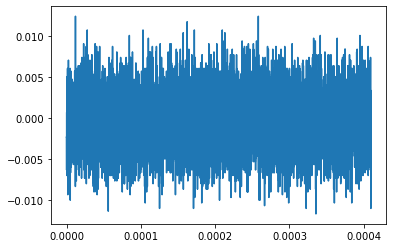

In [1099]:
plt.plot(t, b)

In [63]:
status = ctypes.c_byte()    # variable to store buffer status
dwf.FDwfAnalogInStatus(device_handle, ctypes.c_bool(True), ctypes.byref(status))
print(status.value)

1


In [57]:
dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(True))

1

In [58]:
dwf.FDwfAnalogInConfigure(device_handle, ctypes.c_bool(False), ctypes.c_bool(True))

1